# Introduction

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

- [Keras Documentation](https://keras.io/examples/vision/image_classification_from_scratch/)


In [22]:
pip install tensorflow keras matplotlib pydot pydotplus graphviz pyyaml h5py

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the data: the Turtle vs Penguim dataset

In [3]:
!ls .

animals_enormous  model.png	   save_at_3.keras
animals_medium	  save_at_1.keras  turtle_vs_penguin.ipynb
animals_small	  save_at_2.keras  turtle_vs_penguin.py


In [4]:
!ls ./animals_medium

train  valid


In [5]:
!ls ./animals_medium/train/penguins -1 | wc -l

101


In [6]:
!ls ./animals_medium/train/turtles -1 | wc -l

101


# Generate a Dataset

In [7]:
image_size = (512, 512)
batch_size = 12

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "./animals_medium/train",
    validation_split=0.2,
    subset="both",
    seed=123456,
    image_size=image_size,
    batch_size=batch_size,
)

Found 202 files belonging to 2 classes.
Using 162 files for training.
Using 40 files for validation.


# Visualize the data

2024-04-18 16:05:06.003226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


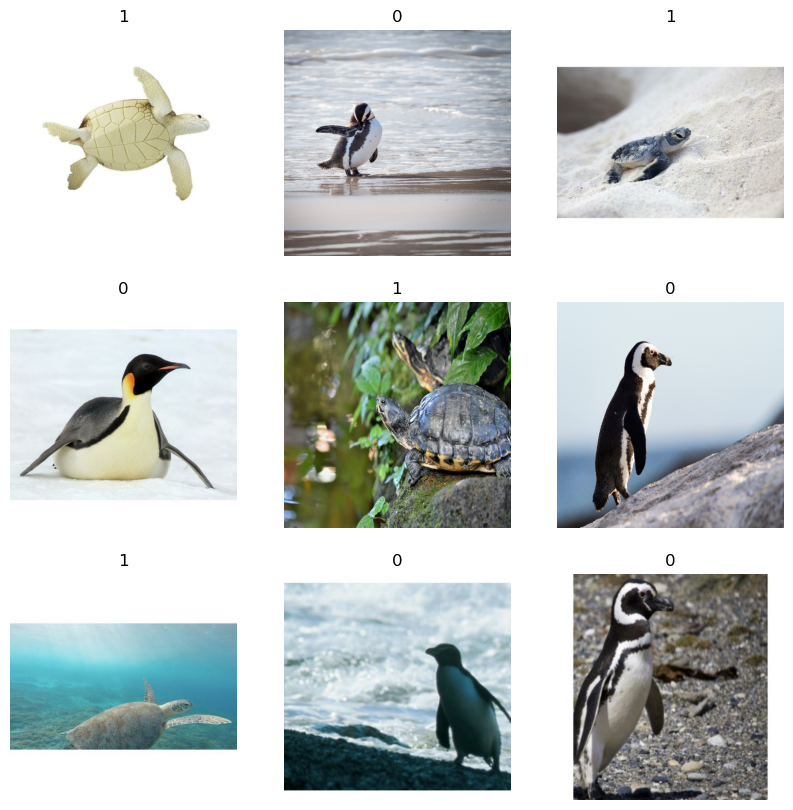

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation

In [9]:
AUG = {
    # AUGMENTATION
    'AUGMENTATION_RANDOM_FLIP': 'horizontal',
    'AUGMENTATION_RANDOM_ROTATION':0.5,
    'AUGMENTATION_RANDOM_ZOOM':0.2,
    'AUGMENTATION_RESCALING': 1./255,
    'AUGMENTATION_RANDOM_CONTRAST_FACTOR':0.2,
    'AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR':0.1, 
    'AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR':0.1, 
    'AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE':'reflect', 
    'AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION':'bilinear',
    'DIRECTORY_SEED': 123456,
}

In [10]:
AUGMENTATION = keras.Sequential(
  [
    layers.RandomFlip(
        AUG['AUGMENTATION_RANDOM_FLIP']
    ),
    layers.RandomRotation(
        AUG['AUGMENTATION_RANDOM_ROTATION']
    ),
    layers.RandomZoom(
        AUG['AUGMENTATION_RANDOM_ZOOM']
    ),
    layers.RandomContrast(
        factor=AUG['AUGMENTATION_RANDOM_CONTRAST_FACTOR'],
        seed=AUG['DIRECTORY_SEED']
    ),
    layers.RandomTranslation(
        height_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR'],
        width_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR'],
        fill_mode=AUG['AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE'],
        interpolation=AUG['AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION'],
        seed=AUG['DIRECTORY_SEED'],
    ),
  ]
)

2024-04-18 16:05:14.200828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


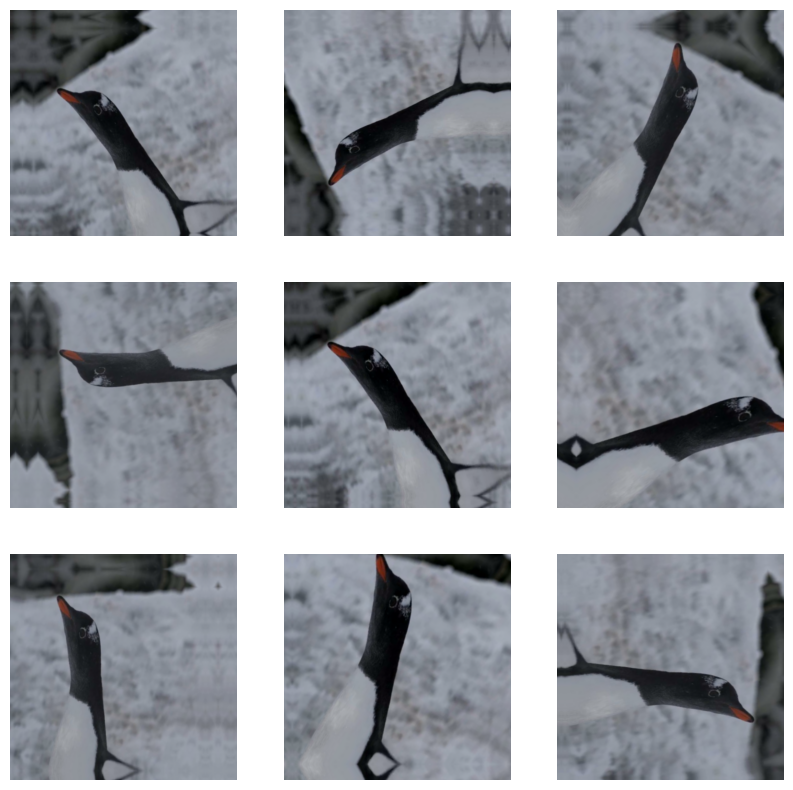

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = AUGMENTATION(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (AUGMENTATION(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Build a model

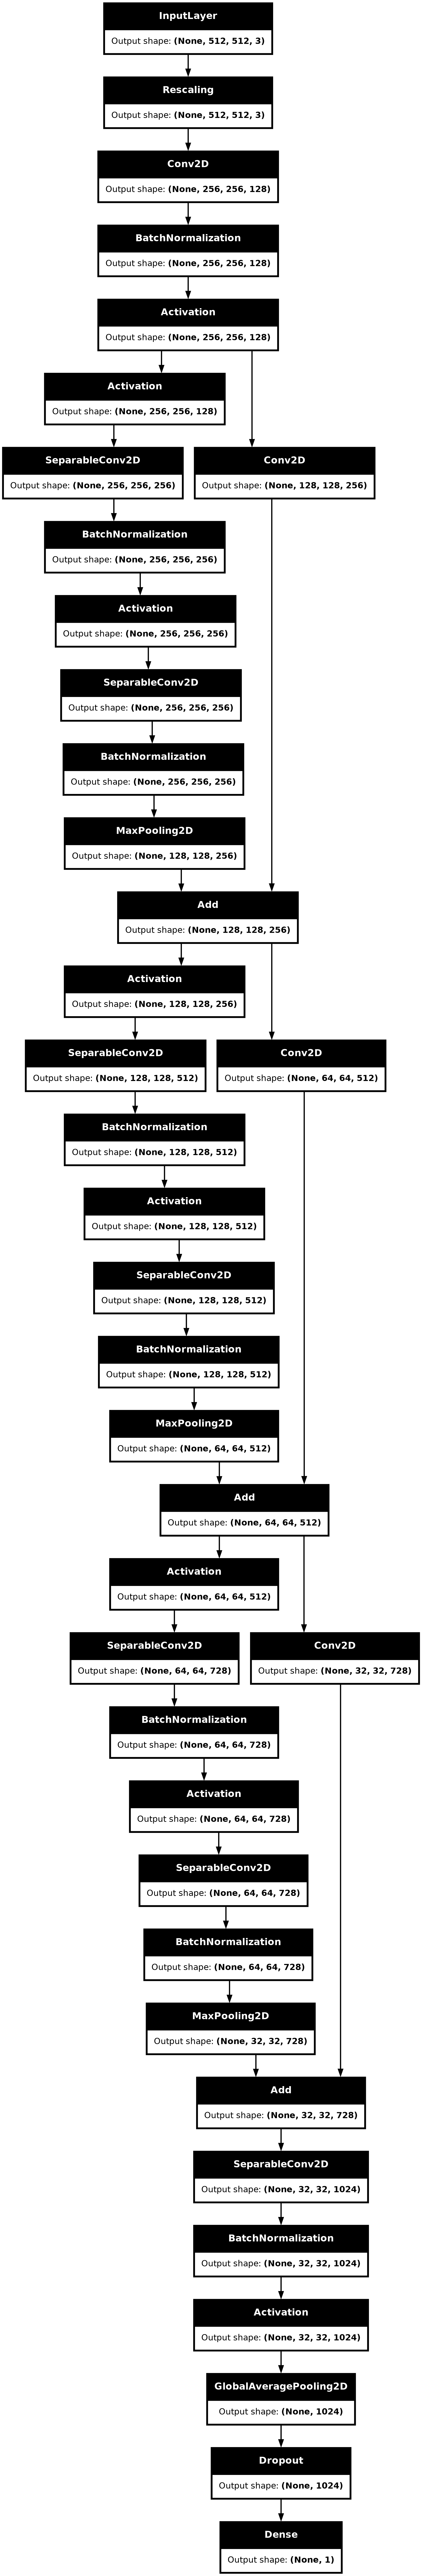

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Train the model

In [14]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 283s 19s/step - accuracy: 0.6232 - loss: 0.8604 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 321s 19s/step - accuracy: 0.5729 - loss: 0.7332 - val_accuracy: 0.5750 - val_loss: 0.6924
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 315s 19s/step - accuracy: 0.7077 - loss: 0.7430 - val_accuracy: 0.5250 - val_loss: 0.6906
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 327s 19s/step - accuracy: 0.7023 - loss: 0.6013 - val_accuracy: 0.5250 - val_loss: 0.6897
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 273s 19s/step - accuracy: 0.6699 - loss: 0.6975 - val_accuracy: 0.5250 - val_loss: 0.6879
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 277s 19s/step - accuracy: 0.6983 - loss: 0.6442 - val_accuracy: 0.5250 - val_loss: 0.6876
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 274s 19s/step - accuracy: 0.7823 - loss: 0.5978 - val_accuracy: 0.5250 - val_loss: 0.6917
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 274s 19s/step - accuracy: 0.6680 - loss: 0.5947 - val_accuracy: 0.

# Run inference on new data

In [15]:
img = keras.utils.load_img(
    "./animals_medium/valid/turtles/104_turtle.png", target_size=image_size
)

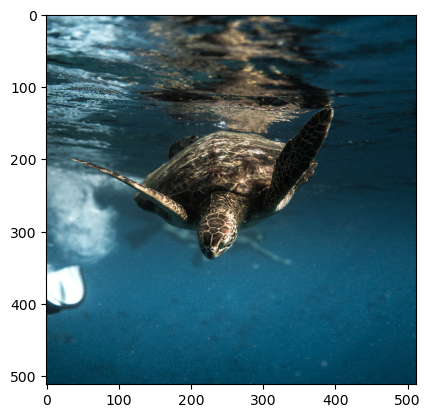

In [16]:
plt.imshow(img)

In [17]:
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

In [18]:
predictions = model.predict(img_array)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


array([[0.48071104]], dtype=float32)

In [19]:
score = float(predictions[0])
score

/tmp/ipykernel_2037/2314994182.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


0.48071104288101196

In [21]:
print(f"This image is {100 * (1 - score):.2f}% penguim and {100 * score:.2f}% turtle.")

This image is 51.93% penguim and 48.07% turtle.


In [23]:
model.save("turtle_v_pengin_model.keras")